# MNIST - with PyTorch SGD

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
tfs = [transforms.ToTensor(), transforms.Normalize(mean, std)]
transform = transforms.Compose(tfs)

In [4]:
ds_train = datasets.MNIST(root='data', download=True, train=True, transform=transform)
ds_test = datasets.MNIST(root='data', download=True, train=False, transform=transform)
len(ds_train), len(ds_test)

(60000, 10000)

In [5]:
BS = 64
loader_train = torch.utils.data.DataLoader(ds_train, batch_size=BS, shuffle=True, num_workers=4)
loader_test = torch.utils.data.DataLoader(ds_train, batch_size=BS, shuffle=True, num_workers=4)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # starts with 1*28*28
        self.conv1 = nn.Conv2d(1, 20, 3, padding=1) 
        self.conv2 = nn.Conv2d(20, 50, 3, padding=1) 

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(50*7*7, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        relu = nn.ReLU()
        
        x = relu(self.conv1(x)) # (1, 28, 28) -> (20, 28, 28)
        x = self.pool(x) # (20, 28, 28) -> (20, 14, 14)
        
        x = relu(self.conv2(x)) # (20, 14, 14) -> (50, 14, 14)
        x = self.pool(x) # (50, 14, 14) -> (50, 7, 7)
        
        x = x.view(-1, 50*7*7)

        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

[1, 9, 0, 2, 3, 8, 7, 9]
[4, 9, 0, 4, 4, 5, 8, 8]


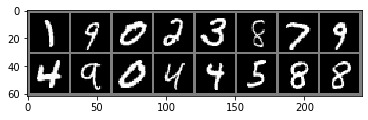

In [7]:
def imshow(img):
    img = (img * 0.5) + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(loader_train))

imgs = images[:16]
lbls = labels[:16]
imshow(torchvision.utils.make_grid(imgs))
l = list(lbls.numpy())
print(l[:len(l)//2])
print(l[len(l)//2:])

In [8]:
model = Network()
model.to(device)
model

Network(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2450, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)

In [9]:
def train(model, loader, optimizer, criterion, epoch):
    loss_train = 0
    for batch_idx, (data, labels) in enumerate(loader):
        print('Batch {}'.format(batch_idx), end='\r')
        model.train()
        
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train += loss.item() * labels.size(0)

    loss_train /= len(loader_train.dataset)
    return loss_train

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=0.9)

In [11]:
epochs = 2

ckpt = './model/ckpt-pysgd.pt'
os.makedirs('model', exist_ok=True)

if os.path.exists(ckpt):
    print('Loading Previous Results')
    ckpt_loaded = torch.load(ckpt, map_location=device)
    model.load_state_dict(ckpt_loaded['model_weights'])
    loss = ckpt_loaded['loss']
else:
    print('First Iteration')
    loss = 9999


for epoch in range(epochs):
    loss_e = train(model, loader_train, optimizer, criterion, epoch+1)
    if loss_e < loss:
        loss = loss_e
        model_weights = copy.deepcopy(model.state_dict())
        ckpt_dict = {
            'model_weights': model_weights,
            'loss':loss
        }
        torch.save(ckpt_dict, ckpt)
        print('Train: {:2d} Loss {:.3f} - model saved'.format(epoch+1, loss_e))
    else:
        print('Train: {:2d} Loss {:.3f}'.format(epoch+1, loss_e))


First Iteration
Train:  1 Loss 0.346 - model saved
Train:  2 Loss 0.103 - model saved


In [12]:
def test(model, loader, criterion):
    preds_ds, labels_ds = [], []
    
    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            
            preds = outputs.argmax(dim=1, keepdim=True)
            preds = preds.view_as(labels)
            
            preds_ds.append(list(preds.cpu().numpy()))
            labels_ds.append(list(labels.cpu().numpy()))
            
    return preds_ds, labels_ds
preds_ds, labels_ds = test(model, loader_test, criterion)

In [13]:
y_pred = preds_ds[0]
y_true = labels_ds[0]
print('Accuracy Score {}'.format(accuracy_score(y_true, y_pred)))

Accuracy Score 1.0


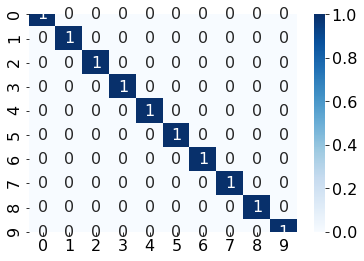

In [14]:
cm = confusion_matrix(y_true=y_true , y_pred=y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#plt.figure(figsize=(20,15))
plt.rcParams.update({'font.size': 16})
sns.heatmap(cm, annot=True, cmap='Blues');

In [15]:
accuracy_score(y_true, y_pred)

1.0